# MTU Geophones

In [1]:
import numpy as np
import pandas as pd
import obspy
from scipy.optimize import curve_fit
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(12, 9))
plt.rc('font', size=15)
%matplotlib inline

## Data Loading

In [2]:
import datarepo
from datarepo import xy, xyz, lxy, lxyz
pos = datarepo.get_pos()
pos.columns

Index(['label', 'h_off', 'r', 'ϕ', 'θ', 'x_raw', 'y_raw', 'z_raw', 'x', 'y',
       'z', 'latn_m', 'lone_m', 'ht', 'latn_deg', 'lone_deg'],
      dtype='object')

In [3]:
msumm = datarepo.get_byu_mics_summ()
msumm.columns

Index(['pad', 'ch', 'blast', 'pmax', 'tmax', 'pmin', 'tmin', 'noise', 'ts',
       'tarr', 't1', 't2', 'imp1', 'imp2', 'imp', 'm1', 'm2', 'r', 'x', 'y',
       'z', 'hlabel', 'ppf46', 'alpha', 'depth', 'dbar', 'dredbar', 't', 'c',
       'Ea', 'σEa'],
      dtype='object')

`sos`: Speed of "sound". (Well, some averaged speed of when the pulses arrived at the BYU mics.)

In [4]:
sos = {f"pad{i}": msumm.loc[msumm['pad'] == i, 'c'].iloc[0] for i in (1, 2, 3, 4)}
sos

{'pad1': 341.29035980472821,
 'pad2': 344.98058041272543,
 'pad3': 349.13065907409282,
 'pad4': 350.38694533184656}

### `gppos`

In [5]:
positions = pos.loc[list(range(139, 162)) + [163]]
positions

label  h_off   r   ϕ   θ  x_raw  y_raw  z_raw          x          y  \
point                                                                           
139         gp1    NaN NaN NaN NaN    NaN    NaN    NaN  26.348397  38.654608   
140         gp2    NaN NaN NaN NaN    NaN    NaN    NaN  26.243016  36.042208   
141         gp3    NaN NaN NaN NaN    NaN    NaN    NaN  26.135091  33.324425   
142         gp4    NaN NaN NaN NaN    NaN    NaN    NaN  26.223879  30.875495   
143         gp5    NaN NaN NaN NaN    NaN    NaN    NaN  26.093814  28.116132   
144         gp6    NaN NaN NaN NaN    NaN    NaN    NaN  26.055083  23.013226   
145         gp7    NaN NaN NaN NaN    NaN    NaN    NaN  26.121732  20.522716   
146         gp8    NaN NaN NaN NaN    NaN    NaN    NaN  25.955024  17.996345   
147         gp9    NaN NaN NaN NaN    NaN    NaN    NaN  26.016581  15.295066   
148        gp10    NaN NaN NaN NaN    NaN    NaN    NaN  25.911201  12.682670   
149        gp11    NaN NaN NaN NaN    NaN    NaN    NaN  25.847556  10.048052   
150        gp12    NaN NaN NaN NaN    NaN    NaN    NaN  25.872470   7.579761   
151        gp13    NaN NaN NaN NaN    NaN    NaN    NaN  25.831194   2.371463   
152        gp14    NaN NaN NaN NaN    NaN    NaN    NaN  25.841552  -2.768807   
153        gp15    NaN NaN NaN NaN    NaN    NaN    NaN  25.798812  -7.951155   
154        gp16    NaN NaN NaN NaN    NaN    NaN    NaN  25.723970 -13.324612   
155        gp17    NaN NaN NaN NaN    NaN    NaN    NaN  25.796392 -18.290665   
156        gp18    NaN NaN NaN NaN    NaN    NaN    NaN  25.533260 -23.494464   
157        gp19    NaN NaN NaN NaN    NaN    NaN    NaN  25.487209 -28.813846   
158        gp20    NaN NaN NaN NaN    NaN    NaN    NaN  25.429122 -33.887797   
159        gp21    NaN NaN NaN NaN    NaN    NaN    NaN  25.213438 -39.008882   
160        gp22    NaN NaN NaN NaN    NaN    NaN    NaN  25.362299 -44.223850   
161        gp23    NaN NaN NaN NaN    NaN    NaN    NaN  25.173353 -49.412318   
163    acoustic    NaN NaN NaN NaN    NaN    NaN    NaN  26.182603  25.667203   

          z        latn_m         lone_m        ht   latn_deg   lone_deg  
point                                                                     
139   -1.28  4.708170e+06  695985.387176  403.3815  42.501078 -78.614787  
140   -1.28  4.708167e+06  695986.586595  403.3815  42.501057 -78.614773  
141   -1.28  4.708165e+06  695987.835880  403.3815  42.501035 -78.614759  
142   -1.28  4.708163e+06  695989.123314  403.3815  42.501015 -78.614744  
143   -1.28  4.708160e+06  695990.373900  403.3815  42.500993 -78.614730  
144   -1.25  4.708156e+06  695992.862052  403.4115  42.500952 -78.614701  
145   -1.00  4.708154e+06  695994.150787  403.6615  42.500933 -78.614686  
146   -0.75  4.708152e+06  695995.254375  403.9115  42.500912 -78.614673  
147   -0.50  4.708149e+06  695996.642845  404.1615  42.500891 -78.614657  
148   -0.25  4.708147e+06  695997.842261  404.4115  42.500870 -78.614643  
149    0.00  4.708145e+06  695999.088942  404.6615  42.500848 -78.614629  
150    0.00  4.708142e+06  696000.330415  404.6615  42.500829 -78.614615  
151    0.00  4.708138e+06  696002.868438  404.6615  42.500787 -78.614585  
152    0.00  4.708133e+06  696005.417731  404.6615  42.500746 -78.614556  
153    0.00  4.708129e+06  696007.941656  404.6615  42.500705 -78.614527  
154    0.00  4.708124e+06  696010.532120  404.6615  42.500662 -78.614497  
155    0.00  4.708120e+06  696013.049271  404.6615  42.500623 -78.614468  
156    0.20  4.708115e+06  696015.392200  404.8615  42.500580 -78.614441  
157    0.40  4.708111e+06  696017.980969  405.0615  42.500538 -78.614411  
158    0.50  4.708106e+06  696020.437984  405.1615  42.500497 -78.614383  
159    0.75  4.708102e+06  696022.781286  405.4115  42.500456 -78.614356  
160    1.00  4.708097e+06  696025.487901  405.6615  42.500415 -78.614324  
161    1.00  4.708093e+06  696027.887748  405.6615  42.500373 -78.614297  
163   -1.25  4.708158e+06  6

In [6]:
gppos = positions.loc[:161]
# gppos

In [7]:
posmap = {1: [6, 7, 8], 2: [10, 11, 12], 3: [13, 14, 15], 4: [17, 18, 19]}
pap = posmap[1] + posmap[2] + posmap[3] + posmap[4]
pap

[6, 7, 8, 10, 11, 12, 13, 14, 15, 17, 18, 19]

In [8]:
pos.loc[pap, lxyz]

label       x       y      z
point                                     
6       pad1, pipe1  15.481  51.474 -1.273
7       pad1, pipe2  16.096  51.427 -1.284
8       pad1, pipe3  16.712  51.357 -1.263
10      pad2, pipe2  19.718  51.157 -1.245
11      pad2, pipe3  20.349  51.083 -1.242
12     pad2, pipe1a  22.894  50.031 -1.275
13      pad3, pipe1  22.874  50.027 -1.265
14      pad3, pipe2  23.183  50.533 -1.270
15      pad3, pipe3  23.493  50.002 -1.265
17      pad4, pipe2  26.317  50.168 -1.283
18      pad4, pipe3  26.581  49.628 -1.254
19     pad1, balls1  15.240  51.485 -1.433

In [9]:
padcenter = pos.loc[[13, 15], xyz].sum(axis=0) / 2
padcenter

x    23.1835
y    50.0145
z    -1.2650
dtype: float64

### Crater Coordinates

In [10]:
cratercoords = {i: pos.loc[posmap[i], xyz] for i in (1, 2, 3, 4)}
cratercoords

{1:             x       y      z
 point                       
 6      15.481  51.474 -1.273
 7      16.096  51.427 -1.284
 8      16.712  51.357 -1.263,
 2:             x       y      z
 point                       
 10     19.718  51.157 -1.245
 11     20.349  51.083 -1.242
 12     22.894  50.031 -1.275,
 3:             x       y      z
 point                       
 13     22.874  50.027 -1.265
 14     23.183  50.533 -1.270
 15     23.493  50.002 -1.265,
 4:             x       y      z
 point                       
 17     26.317  50.168 -1.283
 18     26.581  49.628 -1.254
 19     15.240  51.485 -1.433}

### `rs`: Geophone Distances from crater

In [11]:
cratercoords[1]

x       y      z
point                       
6      15.481  51.474 -1.273
7      16.096  51.427 -1.284
8      16.712  51.357 -1.263

In [12]:
rs = {
    1: np.sqrt(np.sum((positions.loc[:, xyz] - cratercoords[1].values[1]) ** 2,
                      axis=1)),
    2: np.sqrt(np.sum((positions.loc[:, xyz] - cratercoords[2].values[1]) ** 2,
                      axis=1)),
    3: np.sqrt(np.sum((positions.loc[:, xyz] - cratercoords[3].sum(axis=0) / 3) ** 2,
                      axis=1)),
    4: np.sqrt(np.sum((positions.loc[:, xyz] - cratercoords[4].sum(axis=0) / 3) ** 2,
                      axis=1))
}

gprs = {i: rs[i].loc[:161] for i in (1, 2, 3, 4)}

### Data Format

In [13]:
ls '../data/MTU_seis_infr/compact/Shot1SAC'

Shot1_01.sac  Shot1_07.sac  Shot1_13.sac  Shot1_19.sac  Shot1_XMBI_HDF.sac
Shot1_02.sac  Shot1_08.sac  Shot1_14.sac  Shot1_20.sac  Shot1_XMBS_HH1.sac
Shot1_03.sac  Shot1_09.sac  Shot1_15.sac  Shot1_21.sac  Shot1_XMBS_HH2.sac
Shot1_04.sac  Shot1_10.sac  Shot1_16.sac  Shot1_22.sac  Shot1_XMBS_HHZ.sac
Shot1_05.sac  Shot1_11.sac  Shot1_17.sac  Shot1_23.sac
Shot1_06.sac  Shot1_12.sac  Shot1_18.sac  Shot1_24.sac


In [14]:
dloc = Path('../data/MTU_seis_infr/compact/')

Read data from disk and compute a normalized array.

In [15]:
raw = obspy.read(str(dloc/'Shot1SAC/Shot1_01.sac'))
raw

1 Trace(s) in Stream:
X6... | 2018-07-26T09:55:36.000000Z - 2018-07-26T09:55:39.999500Z | 2000.0 Hz, 8000 samples

In [16]:
raw[0].stats

         network: X6
         station: 
        location: 
         channel: 
       starttime: 2018-07-26T09:55:36.000000Z
         endtime: 2018-07-26T09:55:39.999500Z
   sampling_rate: 1999.9998779296875
           delta: 0.00050000003051758
            npts: 8000
           calib: 4.2704e-05
         _format: SAC
             sac: AttribDict({'delta': 0.00050000002, 'depmin': -526918.44, 'depmax': 526389.38, 'scale': 4.2703999e-05, 'b': 0.0, 'e': 3.9995003, 'depmen': 1410.7833, 'nzyear': 2018, 'nzjday': 207, 'nzhour': 9, 'nzmin': 55, 'nzsec': 36, 'nzmsec': 0, 'nvhdr': 6, 'npts': 8000, 'iftype': 1, 'iztype': 9, 'leven': 1, 'lpspol': 1, 'lovrok': 1, 'lcalda': 0, 'knetwk': 'X6'})

In [17]:
fs = raw[0].stats.sampling_rate
fs

1999.9998779296875

### `get_raw()`

In [18]:
def get_raw(pad:int, ch:int):
    return obspy.read(str(dloc/f'Shot{pad}SAC/Shot{pad}_{ch:02d}.sac'))

### `get_normed()`

In [19]:
def get_normed(pad:int, ch):
    """
    Parameters:
    ----------
    pad : int
    ch : int or 'all'
        Channel number or string 'all'.
    """
    if ch == 'all':
        ch = list(range(1, 25))
        ch.pop(5)
    if isinstance(ch, list):
        raw = get_raw(pad, ch[0])[0].data
        mx = np.abs(raw).max()
        normed = np.empty((len(raw), len(ch)))
        normed[:, 0] = raw / mx
        for i, c in enumerate(ch[1:], start=1):
            raw = get_raw(pad, c)[0].data
            mx = np.abs(raw).max()
            normed[:, i] = raw / mx
        return normed
    elif isinstance(ch, int):
        raw = get_raw(pad, ch)[0].data
        mx = np.abs(raw).max()
        return raw / mx

### `pick()`

Currently does:  
Select first index larger than some given threshold for each channel/geophone.

In [20]:
def pick(vals, thresh=3e-3, start=0):
    start = int(start)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        picks = np.array([
            np.where(np.abs(vals[start:, i]) > thresh)[0][0]
            for i in range(vals.shape[1])
        ])
    return picks + start

### `speed_plot()`

Plot speeds

In [21]:
def speed_plot(picks, idx, res, pad):
    fig, ax = plt.subplots()
    fig.set_size_inches(7,7)
    for i in range(len(picks)):
        ax.plot(t[picks[i]], rs[pad].iloc[idx[i]], 'x', color='k')
        ax.plot(
            t[picks[i][[0, -1]]], linear(t[picks[i][[0, -1]]], *res[i]),
            label=r'%d-%d: ${v=%.0f\,\mathrm{ms^{-1}}}$'
                    % (idx[i][0] + 1, idx[i][-1] + 1, res[i][0])
        )
    ax.legend(loc='upper left')
    ax.set_xlabel(r'$t\ /\ \mathrm{s}$')
    ax.set_ylabel(r'$r\ /\ \mathrm{m}$')
    return fig, ax

In [22]:
from materialproperties.explosive import pentex, tnt_equiv
from materialproperties.explosive import pentex

In [23]:
pentex.tnt_equiv_ratio, 1 / (tnt_equiv ** (-1 / 3))

(1.1591778202676863, 161.13772405751092)

Linear function for fit

In [24]:
def linear(x, a, y0):
    return a * x + y0

sampling rate

In [25]:
fs = 2e3

Entry for the asdf files

In [26]:
first_arr = {
    'note':
    "'tblast': Estimated time of blast on the 'local' time line.\n" \
    "'Delta_tc': Time of intercept of first and second identified velocities " \
        "relative to 'tblast'.\n" \
    "'rc': Distance of intercept of the first and second identified velocities." \
    "'vs': Velocities of first arrivals.\n" \
    "'idx': Indices of the t and r arrays that belong to a velocity group."
    "'t': First arrival times.\n", "'r': First arrival distances."
    'pad1': {}, 'pad2': {}, 'pad3': {}, 'pad4': {}
}

## pad 1

In [27]:
normed = get_normed(1, 'all')

In [28]:
normed[np.abs(normed) > .1] = np.nan

In [29]:
normed.shape

(8000, 23)

In [30]:
tf = get_raw(1, 24)

The "06" channel is noisy:

In [31]:
test = obspy.read('../data/MTU_seis_infr/compact/Shot1SAC/Shot1_06.sac')

In [32]:
t = test[0].times()

(0.25, 0.75)

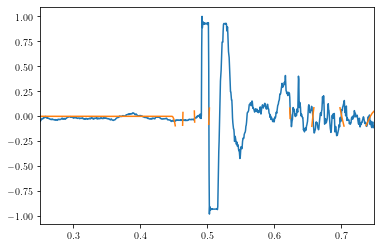

In [33]:
fig, ax = plt.subplots()

ax.plot(t, test[0].data / test[0].max())
ax.plot(t, normed[:, 0])
ax.set_xlim(.25, .75)

In [34]:
picks = pick(normed, start=.4 * fs, thresh=1.5e-3)
picks

array([ 897,  896,  896,  899,  905,  915,  918,  922,  927,  931,  934,
        943,  949,  959,  966,  970,  975,  984,  990,  996, 1002, 1005,
       1012])

In [35]:
t = np.arange(normed.shape[0]) / fs

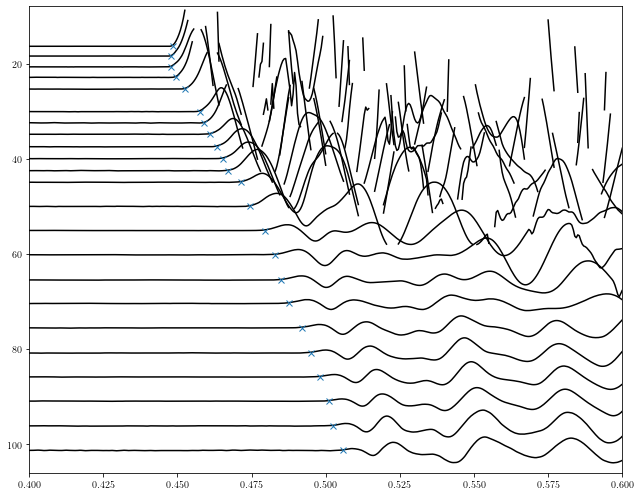

In [36]:
fig, ax = plt.subplots()

for i, r in enumerate(gprs[1]):
    ax.plot(t, 100 * normed[:, i] * .8 + r, color='k')
ax.plot(t[picks], gprs[1], 'x')
ax.set_ylim(106, 8)
ax.set_xlim(.4, .6)
fig.set_size_inches(9, 7)
fig.tight_layout()

In [37]:
picks

array([ 897,  896,  896,  899,  905,  915,  918,  922,  927,  931,  934,
        943,  949,  959,  966,  970,  975,  984,  990,  996, 1002, 1005,
       1012])

channels to 14, skip the first 2 and skip ch 6

In [38]:
idx1 = np.asarray(range(23))
idx1 = np.asarray([el for el in idx1 if el not in (0, 1, 5) and el < 14])
idx1

array([ 2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13])

In [39]:
picks1 = picks[idx1]

In [40]:
result1 = curve_fit(linear, t[picks1], rs[1].iloc[idx1])
result1

(array([ 1084.93271654,  -465.2334547 ]),
 array([[ 405.5295182 , -187.70486887],
        [-187.70486887,   86.91997244]]))

In [41]:
print(f"speed:  {result1[0][0]} m/s,\n"
      f"stddev: {np.sqrt(result1[1][0, 0])},\n"
      f"rel:    {np.sqrt(result1[1][0, 0]) / result1[0][0]}")

speed:  1084.9327165350273 m/s,
stddev: 20.137763485444886,
rel:    0.01856130170888319


select far channels

In [42]:
idx2 = np.asarray(range(14, 23))
idx2

array([14, 15, 16, 17, 18, 19, 20, 21, 22])

In [43]:
picks2 = picks[idx2]

In [44]:
result2 = curve_fit(linear, t[picks2], rs[1].iloc[idx2])
result2

(array([ 1721.33246839,  -770.37565243]),
 array([[ 3003.81135078, -1485.21783503],
        [-1485.21783503,   734.53417217]]))

In [45]:
ls ../data/MTU_seis_infr/compact/Shot1SAC/

Shot1_01.sac  Shot1_07.sac  Shot1_13.sac  Shot1_19.sac  Shot1_XMBI_HDF.sac
Shot1_02.sac  Shot1_08.sac  Shot1_14.sac  Shot1_20.sac  Shot1_XMBS_HH1.sac
Shot1_03.sac  Shot1_09.sac  Shot1_15.sac  Shot1_21.sac  Shot1_XMBS_HH2.sac
Shot1_04.sac  Shot1_10.sac  Shot1_16.sac  Shot1_22.sac  Shot1_XMBS_HHZ.sac
Shot1_05.sac  Shot1_11.sac  Shot1_17.sac  Shot1_23.sac
Shot1_06.sac  Shot1_12.sac  Shot1_18.sac  Shot1_24.sac


In [46]:
rs[1][163] / sos['pad1']

0.081057658841601848

In [47]:
idx3 = [0, 1, 2]
picks3 = picks[idx3]
result3 = curve_fit(linear, t[picks3], rs[1].iloc[idx3])
result3

(array([-6373.20246139,  2874.75951039]),
 array([[ 15461855.20255581,  -6929488.05932087],
        [ -6929488.05932087,   3105566.4030405 ]]))

In [48]:
tblast1 = t[897] - 5e-4

In [49]:
res1, res2 = result1[0], result2[0]

In [50]:
rc1 = [linear(t[picks3[-1]], *res1)]
rc1.append((res1[1] * res2[0] - res2[1] * res1[0]) / (res2[0] - res1[0]))
rc1

[20.816402308021679, 54.972206214393744]

In [51]:
tc1 = np.array([
    tblast1 + 5e-4,
    (res2[1] - res1[1]) / (res1[0] - res2[0])
])
tc1

array([ 0.4485    ,  0.47948196])

Text(0.5, 0.98, 'Pad 1')

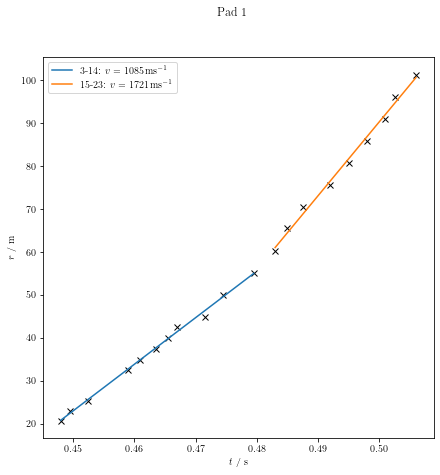

In [52]:
fig, ax = speed_plot([picks1, picks2], [idx1, idx2], [res1, res2], 1)
fig.suptitle('Pad 1')

In [53]:
idx = np.concatenate((idx3, idx1, idx2))
first_arr['pad1'] = {
    'tblast': tblast1, 'Delta_tc': tc1 - tblast1, 'rc': rc1,
    'vs': [res1[0], res2[0]],
    'idx': [idx1, idx2],
    't': t[picks[idx]] - tblast1,
    'r': rs[1].iloc[idx].values
}

## pad 2

In [54]:
normed = get_normed(2, 'all')

In [55]:
normed[np.abs(normed) > .1] = np.nan

In [56]:
picks = pick(normed, start=.53 * fs, thresh=2.5e-3)
picks

array([1066, 1067, 1067, 1071, 1077, 1087, 1091, 1096, 1100, 1104, 1109,
       1117, 1123, 1135, 1143, 1147, 1151, 1160, 1167, 1174, 1180, 1182,
       1189])

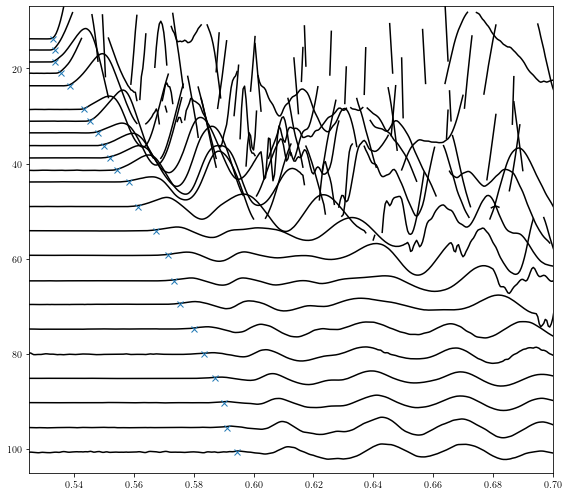

In [57]:
fig, ax = plt.subplots()

for i, r in enumerate(gprs[2]):
    ax.plot(t, 100 * normed[:, i] * .8 + r, color='k')
ax.plot(t[picks], gprs[2], 'x')
ax.set_ylim(105, 7)
ax.set_xlim(.525, .7)
fig.set_size_inches(8, 7)
fig.tight_layout()

In [58]:
picks

array([1066, 1067, 1067, 1071, 1077, 1087, 1091, 1096, 1100, 1104, 1109,
       1117, 1123, 1135, 1143, 1147, 1151, 1160, 1167, 1174, 1180, 1182,
       1189])

channels to 14, skip the first 2 and skip ch 6

In [59]:
idx1 = list(range(23))
idx1 = np.asarray([el for el in idx1 if el not in (0, 1, 5) and el < 14])
idx1

array([ 2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13])

In [60]:
picks1 = picks[idx1]

In [61]:
result1 = curve_fit(linear, t[picks1], rs[2].iloc[idx1])
result1

(array([ 1052.88693488,  -543.01054214]),
 array([[ 317.14328326, -174.28464772],
        [-174.28464772,   95.81111714]]))

In [62]:
print(f"speed:  {result1[0][0]} m/s,\n"
      f"stddev: {np.sqrt(result1[1][0, 0])},\n"
      f"rel:    {np.sqrt(result1[1][0, 0]) / result1[0][0]}")

speed:  1052.8869348764085 m/s,
stddev: 17.808517155125127,
rel:    0.01691398816456541


select far channels

In [63]:
idx2 = list(range(14, 23))
idx2

[14, 15, 16, 17, 18, 19, 20, 21, 22]

In [64]:
picks2 = picks[idx2]

In [65]:
result2 = curve_fit(linear, t[picks2], rs[2].iloc[idx2])
result2

(array([ 1695.12534026,  -908.17763313]),
 array([[ 4723.82882316, -2753.72976724],
        [-2753.72976724,  1605.55973853]]))

In [66]:
idx3 = [0, 1, 2]
picks3 = picks[idx3]
result3 = curve_fit(linear, t[picks3], rs[2].iloc[idx3])
result3

(array([ 7230.51842706, -3840.06562857]),
 array([[ 19096641.68469867, -10184875.54899826],
        [-10184875.54899826,   5431934.67842981]]))

In [67]:
res1, res2, res3 = result1[0], result2[0], result3[0]

In [68]:
tblast2 = -res3[1] / res3[0]
tblast2

0.53109132731035535

In [69]:
rc2 = []
rc2.append((res3[1] * res1[0] - res1[1] * res3[0]) / (res1[0] - res3[0]))
rc2.append((res1[1] * res2[0] - res2[1] * res1[0]) / (res2[0] - res1[0]))
rc2

[18.924275185389696, 55.645122054846752]

In [70]:
tc2 = np.array([
    (res1[1] - res3[1]) / (res3[0] - res1[0]),
    (res2[1] - res1[1]) / (res1[0] - res2[0])
])

In [71]:
tc2 - tblast2

array([ 0.00261728,  0.03749362])

Text(0.5, 0.98, 'Pad 2')

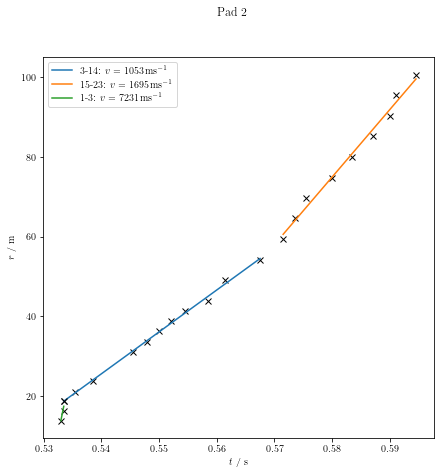

In [72]:
fig, ax = speed_plot([picks1, picks2, picks3], [idx1, idx2, idx3],
                    [res1, res2, res3], 2)
fig.suptitle('Pad 2')

In [73]:
rs.keys()

dict_keys([1, 2, 3, 4])

In [74]:
idx = np.concatenate((idx3, idx1, idx2))
first_arr['pad2'] = {
    'tblast': tblast2, 'Delta_tc': tc2 - tblast2, 'rc': rc2,
    'vs': [res1[0], res2[0]],
    'idx': [idx1, idx2],
    't': t[picks[idx]] - tblast2,
    'r': rs[2].iloc[idx].values
}

## pad 3

In [75]:
normed = get_normed(3, 'all')

In [76]:
normed[np.abs(normed) > .1] = np.nan

In [77]:
picks = pick(normed, start=.35 * fs, thresh=2.5e-3)
picks

array([715, 716, 717, 721, 727, 737, 742, 746, 750, 754, 759, 767, 773,
       784, 792, 797, 801, 811, 817, 824, 831, 833, 838])

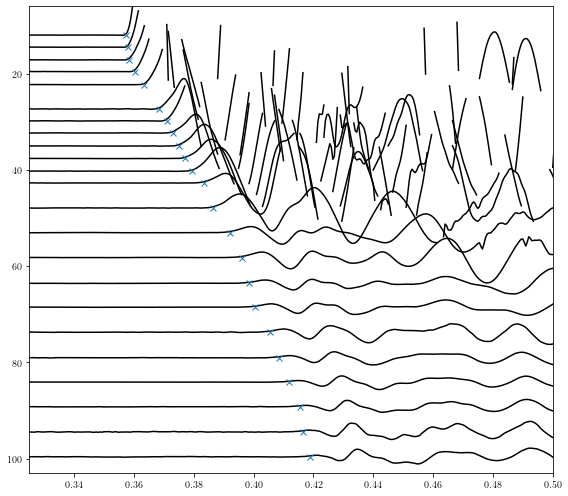

In [78]:
fig, ax = plt.subplots()

for i, r in enumerate(gprs[3]):
    ax.plot(t, 100 * normed[:, i] * .8 + r, color='k')
ax.plot(t[picks], gprs[3], 'x')
ax.set_ylim(103, 6)
ax.set_xlim(.325, .5)
fig.set_size_inches(8, 7)
fig.tight_layout()

In [79]:
picks

array([715, 716, 717, 721, 727, 737, 742, 746, 750, 754, 759, 767, 773,
       784, 792, 797, 801, 811, 817, 824, 831, 833, 838])

channels to 14, skip the first 2 and skip ch 6

In [80]:
idx1 = list(range(23))
idx1 = np.asarray([el for el in idx1 if el not in (0, 1, 5) and el < 14])
idx1

array([ 2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13])

In [81]:
picks1 = picks[idx1]

In [82]:
result1 = curve_fit(linear, t[picks1], rs[3].iloc[idx1])
result1

(array([ 1076.10084009,  -368.72213241]),
 array([[ 352.90491734, -132.17893237],
        [-132.17893237,   49.54392008]]))

In [83]:
print(f"speed:  {result1[0][0]} m/s,\n"
      f"stddev: {np.sqrt(result1[1][0, 0])},\n"
      f"rel:    {np.sqrt(result1[1][0, 0]) / result1[0][0]}")

speed:  1076.1008400921223 m/s,
stddev: 18.785763688089112,
rel:    0.017457252134921584


select far channels

In [84]:
idx2 = list(range(14, 23))
idx2

[14, 15, 16, 17, 18, 19, 20, 21, 22]

In [85]:
picks2 = picks[idx2]

In [86]:
result2 = curve_fit(linear, t[picks2], rs[3].iloc[idx2])
result2

(array([ 1677.32454089,  -605.39432662]),
 array([[ 5381.87425109, -2195.80469263],
        [-2195.80469263,   896.22468106]]))

In [87]:
idx3 = [0, 1, 2]
picks3 = picks[idx3]
result3 = curve_fit(linear, t[picks3], rs[3].iloc[idx3])
result3

(array([ 5160.14644301, -1832.81551543]),
 array([[ 5980.38370294, -2140.97735458],
        [-2140.97735458,   766.47088571]]))

In [88]:
res1, res2, res3 = result1[0], result2[0], result3[0]

In [89]:
tblast3 = -res3[1] / res3[0]
tblast3

0.35518672496423087

In [90]:
rc3 = []
rc3.append((res3[1] * res1[0] - res1[1] * res3[0]) / (res1[0] - res3[0]))
rc3.append((res1[1] * res2[0] - res2[1] * res1[0]) / (res2[0] - res1[0]))
rc3

[17.05027872513239, 54.88583026966424]

In [91]:
tc3 = np.array([
    (res1[1] - res3[1]) / (res3[0] - res1[0]),
    (res2[1] - res1[1]) / (res1[0] - res2[0])
])
tc3

array([ 0.35849095,  0.39365081])

In [92]:
tc3 - tblast3

array([ 0.00330422,  0.03846408])

Text(0.5, 0.98, 'Pad 3')

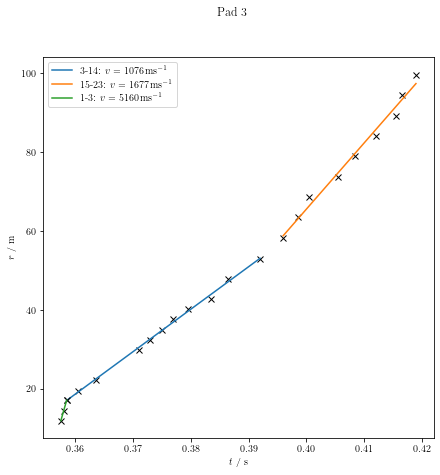

In [93]:
fig, ax = speed_plot([picks1, picks2, picks3], [idx1, idx2, idx3],
                     [res1, res2, res3], 3)
fig.suptitle('Pad 3')

In [94]:
idx3

[0, 1, 2]

In [95]:
idx2

[14, 15, 16, 17, 18, 19, 20, 21, 22]

In [96]:
rs[3].iloc[idx1]

point
141    17.119309
142    19.549737
143    22.262277
145    29.810984
146    32.314222
147    35.015502
148    37.617478
149    40.247540
150    42.711136
151    47.905877
152    53.037943
dtype: float64

In [97]:
len(idx1) + len(idx2) + len(idx3)

23

In [98]:
rs[3]

point
139    11.959162
140    14.472263
141    17.119309
142    19.549737
143    22.262277
144    27.325433
145    29.810984
146    32.314222
147    35.015502
148    37.617478
149    40.247540
150    42.711136
151    47.905877
152    53.037943
153    58.211073
154    63.575361
155    68.539542
156    73.733849
157    79.052337
158    84.123672
159    89.242104
160    94.463523
161    99.645313
163    24.702888
dtype: float64

In [99]:
idx = np.concatenate((idx3, idx1, idx2))
first_arr['pad3'] = {
    'tblast': tblast3, 'Delta_tc': tc3 - tblast3, 'rc': rc3,
    'vs': [res1[0], res2[0]],
    'idx': [idx1, idx2],
    't': t[picks[idx]] - tblast3,
    'r': rs[3].iloc[idx].values
}

## pad 4

In [100]:
normed = get_normed(4, 'all')

In [101]:
normed[np.abs(normed) > .1] = np.nan

In [102]:
picks = pick(normed, start=.6 * fs, thresh=2.5e-3)
picks

array([1215, 1216, 1217, 1220, 1227, 1237, 1241, 1245, 1249, 1254, 1258,
       1267, 1272, 1284, 1292, 1296, 1300, 1308, 1315, 1323, 1328, 1332,
       1337])

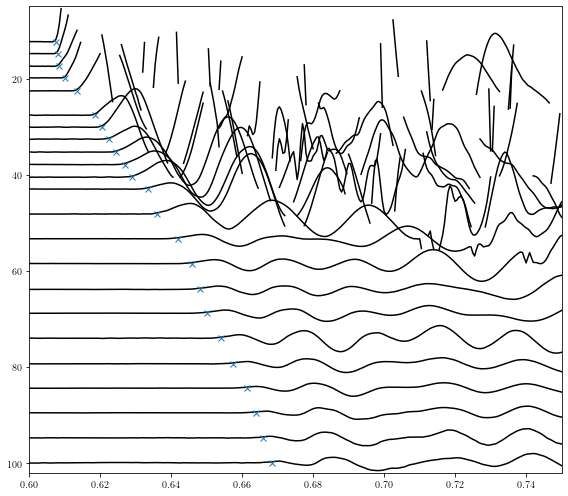

In [103]:
fig, ax = plt.subplots()

for i, r in enumerate(gprs[4]):
    ax.plot(t, 100 * normed[:, i] * .8 + r, color='k')
ax.plot(t[picks], gprs[4], 'x')
ax.set_ylim(102, 5)
ax.set_xlim(.6, .75)
fig.set_size_inches(8, 7)
fig.tight_layout()

In [104]:
picks

array([1215, 1216, 1217, 1220, 1227, 1237, 1241, 1245, 1249, 1254, 1258,
       1267, 1272, 1284, 1292, 1296, 1300, 1308, 1315, 1323, 1328, 1332,
       1337])

channels to 14, skip the first 2 and skip ch 6

In [105]:
idx1 = list(range(23))
idx1 = np.asarray([el for el in idx1 if el not in (0, 1, 5) and el < 14])
idx1

array([ 2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13])

In [106]:
picks1 = picks[idx1]

In [107]:
result1 = curve_fit(linear, t[picks1], rs[4].iloc[idx1])
result1

(array([ 1072.62244211,  -634.99574128]),
 array([[ 508.52762099, -317.45992491],
        [-317.45992491,  198.23486138]]))

In [108]:
print(f"speed:  {result1[0][0]} m/s,\n"
      f"stddev: {np.sqrt(result1[1][0, 0])},\n"
      f"rel:    {np.sqrt(result1[1][0, 0]) / result1[0][0]}")

speed:  1072.6224421079 m/s,
stddev: 22.550556999477813,
rel:    0.021023760192040945


select far channels

In [109]:
idx2 = list(range(14, 23))
idx2

[14, 15, 16, 17, 18, 19, 20, 21, 22]

In [110]:
picks2 = picks[idx2]

In [111]:
result2 = curve_fit(linear, t[picks2], rs[4].iloc[idx2])
result2

(array([ 1711.51185135, -1045.728054  ]),
 array([[ 3946.7376028 , -2594.10292095],
        [-2594.10292095,  1705.28390883]]))

In [112]:
idx3 = [0, 1, 2]
picks3 = picks[idx3]
result3 = curve_fit(linear, t[picks3], rs[4].iloc[idx3])
result3

(array([ 5120.59600934, -3098.46419365]),
 array([[ 6471.64521886, -3934.76032487],
        [-3934.76032487,  2392.33537546]]))

In [113]:
res1, res2, res3 = result1[0], result2[0], result3[0]

In [114]:
tblast4 = -res3[1] / res3[0]
tblast4

0.60509834948879715

In [115]:
rc4 = []
rc4.append((res3[1] * res1[0] - res1[1] * res3[0]) / (res1[0] - res3[0]))
rc4.append((res1[1] * res2[0] - res2[1] * res1[0]) / (res2[0] - res1[0]))
rc4

[17.768290787830413, 54.576960902095216]

In [116]:
tc4 = (res2[1] - res1[1]) / (res1[0] - res2[0])
tc4

0.642884835436066

In [117]:
tc4 = np.array([
    (res1[1] - res3[1]) / (res3[0] - res1[0]),
    (res2[1] - res1[1]) / (res1[0] - res2[0])
])
tc4

array([ 0.60856831,  0.64288484])

In [118]:
tc4 - tblast4

array([ 0.00346997,  0.03778649])

Text(0.5, 0.98, 'Pad 4')

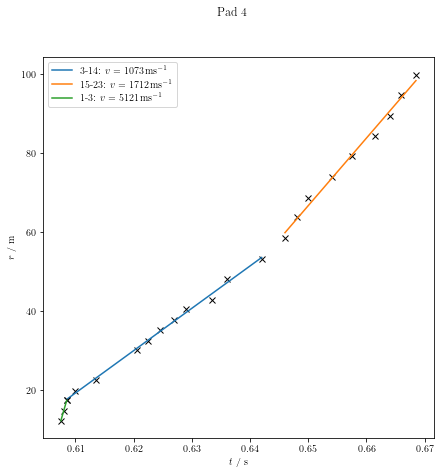

In [119]:
fig, ax = speed_plot([picks1, picks2, picks3], [idx1, idx2, idx3],
                     [res1, res2, res3], 4)
fig.suptitle('Pad 4')

In [120]:
idx = np.concatenate((idx3, idx1, idx2))
first_arr['pad4'] = {
    'tblast': tblast4, 'Delta_tc': tc4 - tblast4, 'rc': rc4,
    'vs': [res1[0], res2[0]],
    'idx': [idx1, idx2],
    't': t[picks[idx]] - tblast4,
    'r': rs[4].iloc[idx].values
}

## Save First Arrivals to `asdf`

In [121]:
import asdf
dbloc = Path('../data/MTU_seis_infr/asdf')

In [122]:
# af = asdf.AsdfFile(uri='../data/MTU_seis_infr/asdf/mtu_seis_inf.asdf')
af = asdf.open(dbloc / 'mtu_seis_inf.asdf', mode='rw')

In [123]:
if 'gp' not in af.keys():
    af['gp'] = {}
af['gp']['first_arr'] = first_arr

In [124]:
af.info(max_rows=None, max_cols=None)

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.1
├─history (dict)
│ └─extensions (list)
│   └─[0] (ExtensionMetadata)
│     ├─extension_class (str): asdf.extension.BuiltinExtension
│     └─software (Software)
│       ├─name (str): asdf
│       └─version (str): 2.8.1
└─gp (dict)
  └─first_arr (dict)
    ├─note (str): 'tblast': Estimated time of blast on the 'local' time line.
'Delta_tc': Time of intercept of first and second identified velocities relative to 'tblast'.
'rc': Distance of intercept of the first and second identified velocities.'vs': Velocities of first arrivals.
'idx': Indices of the t and r arrays that belong to a velocity group.'t': First arrival times.

    ├─'r': First arrival distances.pad1 (dict)
    ├─pad2 (dict)
    │ ├─tblast (float64): 0.5310913273103554
    │ ├─Delta_tc (ndarray): shape=(2,), dtype=float64
    │ ├─rc (list)
    │ 

In [125]:
af.close()